<a href="https://colab.research.google.com/github/Sergey10603/tl_open/blob/main/tl_category_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Скачивание данных

In [1]:
# библиотеки

import zipfile
import numpy as np
import pandas as pd
import os
import csv
import shutil
import glob
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers

In [2]:
# удаление папки со всем содержимым
try:
  shutil.rmtree(dir)
except:
  pass

In [3]:
# переменные

img_size = 150
batch_size = 20

dir = '/content/data/'

path_train = "data_train"
path_validation = "data_validation"

In [4]:
# подключаем гугл диск

drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [5]:
# создаем папку для файлов

!mkdir /content/data

In [6]:
# разархивируем архив (из гугл диска в Colab)

# путь к файлу с архивом
dir_zip = '/content/drive/MyDrive/Colab Notebooks/projects/tl_category_recognition/lights.zip'
# путь к файлу с результатом
dir_res = dir

z = zipfile.ZipFile(dir_zip, 'r')
z.extractall(dir_res)

## Подготовка данных

In [7]:
# создаем структуру папок

# создаем деррикторию для обучающей выборки
try:
    os.mkdir(dir + path_train)
except:
    pass

# создаем деррикторию для контрольной группы
try:
    os.mkdir(dir + path_validation)
except:
    pass

# создаем папки в дерриктории для обучающей выборки
try:
    os.mkdir(dir + path_train + "/cell")
except:
    pass
try:
    os.mkdir(dir + path_train + "/nastol")
except:
    pass
try:
    os.mkdir(dir + path_train + "/podves")
except:
    pass

# создаем папки в дерриктории для контрольной группы
try:
    os.mkdir(dir + path_validation + "/cell")
except:
    pass
try:
    os.mkdir(dir + path_validation + "/nastol")
except:
    pass
try:
    os.mkdir(dir + path_validation + "/podves")
except:
    pass

In [8]:
# раскладываем изображения по папкам

# каждую S картинку берем в контрольную группу
step = 7

# получаем список папок (категорий)
all_folders = os.listdir(dir + "lights/")

# проходимся в цикле по всемпапкам
for folder in all_folders:

  # смотрим все названия изображений в этой папке
  all_imgs = os.listdir(dir + "lights/" + folder + "/")

  # перебираем изображения
  i = 0
  for img in all_imgs:
    i += 1

    if i == step:
      # помещаем в тестовую группу
      old_path = dir + 'lights/' + folder + "/" + img
      new_path = dir + path_validation + "/" + folder + "/" + img

      # проверка изображения на существование в новой папке
      if os.path.exists(new_path) == False:
        shutil.copyfile(old_path, new_path)
        i = 0
    else:
      # помещаем в обучающую группу
      old_path = dir + 'lights/' + folder + "/" + img
      new_path = dir + path_train + "/" + folder + "/" + img


      # проверка изображения на существование в новой папке
      if os.path.exists(new_path) == False:
        shutil.copyfile(old_path, new_path)

In [9]:
# проверяем сколько изображений в папках

# получаем список папок (категорий)
all_folders = os.listdir(dir + "lights/")

# считаем кол-во папок, так как дальше пригодится
count_categories = len(all_folders)

count_imgs_train = 0
count_imgs_validation = 0

# проходимся в цикле по всем папкам
for folder in all_folders:
  print('/--' + str(folder) + '--/')
  print(str(len(glob.glob(dir + path_train + '/' + folder + '/*'))) + ' (train)')
  print(str(len(glob.glob(dir + path_validation + '/' + folder + '/*'))) + ' (validation)')
  print('\n')

  # заодно подсчитываем сколько всех изображений в обучающей и контрольных группах (папках)
  count_imgs_train += len(glob.glob(dir + path_train + '/' + folder + '/*'))
  count_imgs_validation += len(glob.glob(dir + path_validation + '/' + folder + '/*'))


print(str(count_imgs_train) + ' (count_imgs_train)')
print(str(count_imgs_validation) + ' (count_imgs_validation)')

/--cell--/
2371 (train)
395 (validation)


/--podves--/
4033 (train)
672 (validation)


/--nastol--/
1114 (train)
185 (validation)


7518 (count_imgs_train)
1252 (count_imgs_validation)


In [10]:
# изображения (для обучения)

# масштабируем значения с коэффициентом 1/255
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # fill_mode = 'nearest'
)

train_generator = train_datagen.flow_from_directory(
    dir + path_train,
    target_size=(img_size, img_size), 
    batch_size=batch_size,
    class_mode="categorical",
    # interpolation="nearest",
    # shuffle = True
)

Found 7518 images belonging to 3 classes.


In [11]:
# изображения (для проверки)

# масштабируем значения с коэффициентом 1/255
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    dir + path_validation,
    target_size=(img_size, img_size), 
    batch_size=batch_size,
    class_mode="categorical",
    # interpolation="nearest",
    # shuffle = True
)

Found 1252 images belonging to 3 classes.


In [12]:
# названия классов

dict_class = train_generator.class_indices

# для удобства поворачиваем словарь
name_class = {}
for key, value in dict_class.items():
  name_class[value] = key

print(name_class)

{0: 'cell', 1: 'nastol', 2: 'podves'}


## Нейронная сеть

In [13]:
# создаем экземпляр сверточной нейронной сети VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))


58892288/58889256 [==============================] - 0s 0us/step


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

In [246]:
# архетиктура нейронной сети

# network = Sequential()
# network.add(EfficientNetB3(input_shape = (img_size, img_size, 3), include_top = False,
#                         weights = 'imagenet',
#                         drop_connect_rate=0.6))
# network.add(GlobalAveragePooling2D())
# network.add(Flatten())
# network.add(Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
# network.add(Dropout(0.5))
# network.add(Dense(count_categories, activation = 'softmax'))

In [18]:
# архетиктура нейронной сети


network = models.Sequential()

network.add(conv_base)
network.add(layers.Flatten())
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dense(count_categories, activation='softmax'))


# архетиктура нейронной сети

# network = models.Sequential()

# network.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
# network.add(layers.MaxPooling2D((2, 2)))

# network.add(layers.Conv2D(64, (3, 3), activation='relu'))
# network.add(layers.MaxPooling2D((2, 2)))

# network.add(layers.Conv2D(128, (3, 3), activation='relu'))
# network.add(layers.MaxPooling2D((2, 2)))

# network.add(layers.Conv2D(128, (3, 3), activation='relu'))
# network.add(layers.MaxPooling2D((2, 2)))

# добавляем классификатор
# network.add(layers.Flatten())
# network.add(layers.Dropout(0.5))
# network.add(layers.Dense(512, activation='relu'))
# network.add(layers.Dense(count_categories, activation='softmax'))

In [223]:
# network.summary()

In [19]:
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits = False, 
    label_smoothing=0.0001, 
    name='categorical_crossentropy')

network.compile(
    optimizer = Adam(learning_rate = 1e-3), 
    loss = loss, 
    metrics = ['categorical_accuracy'])

# Остановить обучение, когда val_loss перестанет уменьшаться в течение 3 эпох.
es = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    patience=3,
    restore_best_weights=True, 
    verbose=1)

# Сохраняем модель с минимальной потерей
checkpoint_cb = ModelCheckpoint(
    "tl_category_recognition_best_model.h5", 
    save_best_only=True, 
    monitor = 'val_loss', 
    mode='min')

# снижаем скорость обучения
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    patience = 2, 
    min_lr = 1e-6, 
    mode = 'min', 
    verbose = 1)

history = network.fit(
    train_generator, 
    validation_data = validation_generator, 
    epochs= 50, 
    batch_size = batch_size, 
    steps_per_epoch = count_imgs_train // batch_size,
    validation_steps = count_imgs_validation // batch_size, 
    callbacks=[es, checkpoint_cb, reduce_lr])

network.save('tl_category_recognition'+'.h5')  

Epoch 1/50
375/375 [==============================] - 69s 138ms/step - loss: 1.0645 - categorical_accuracy: 0.6158 - val_loss: 0.5398 - val_categorical_accuracy: 0.7976
Epoch 2/50
375/375 [==============================] - 51s 135ms/step - loss: 0.6398 - categorical_accuracy: 0.7418 - val_loss: 0.6026 - val_categorical_accuracy: 0.7597
Epoch 3/50
375/375 [==============================] - 50s 134ms/step - loss: 0.5165 - categorical_accuracy: 0.8087 - val_loss: 0.3164 - val_categorical_accuracy: 0.8968
Epoch 4/50
375/375 [==============================] - 50s 133ms/step - loss: 0.3922 - categorical_accuracy: 0.8586 - val_loss: 0.2605 - val_categorical_accuracy: 0.9194
Epoch 5/50
375/375 [==============================] - 50s 134ms/step - loss: 0.3563 - categorical_accuracy: 0.8733 - val_loss: 0.2562 - val_categorical_accuracy: 0.9161
Epoch 6/50
375/375 [==============================] - 51s 135ms/step - loss: 0.3608 - categorical_accuracy: 0.8649 - val_loss: 0.3001 - val_categorical_acc

In [20]:
# # компилируем
# network.compile(
#     loss='categorical_crossentropy', 
#     optimizer='adam', 
#     metrics=['accuracy']
# )

In [21]:
#  обучаем

# чем меньше группа тем большую важность мы ей даем (на глаз), чтобы не душили крупные группы
# class_weight = {
#     0: 2, 
#     1: 3, 
#     2: 1}

# history = network.fit(
#     train_generator,
#     steps_per_epoch=count_imgs_train // batch_size,
#     epochs=10,
#     validation_data=validation_generator,
#     validation_steps=count_imgs_validation // batch_size,
#     # class_weight=class_weight,
# )

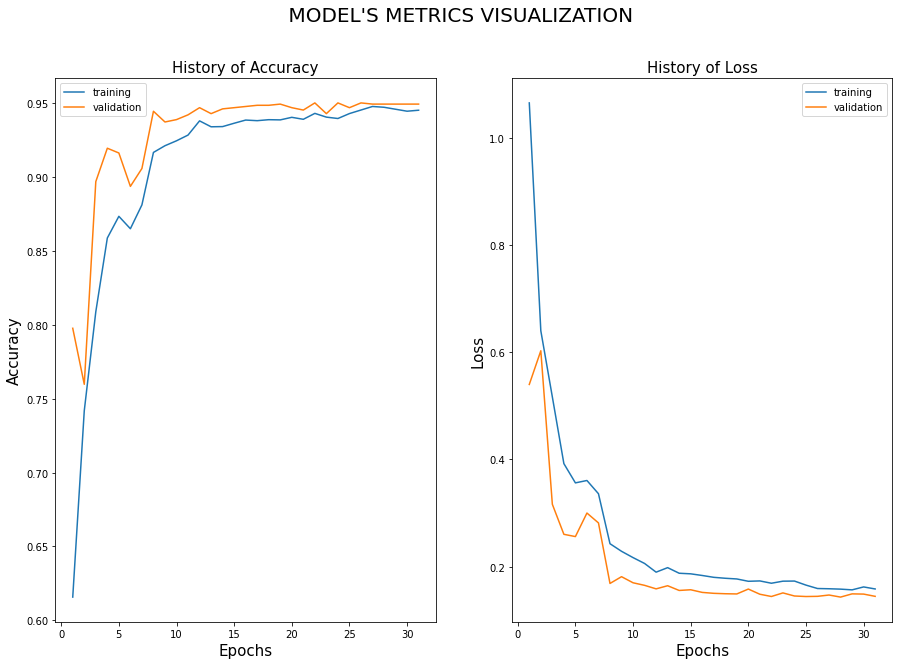

In [23]:
# графики

def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(
    history.history['categorical_accuracy'], 
    history.history['val_categorical_accuracy'], 
    history.history['loss'], 
    history.history['val_loss'])

In [24]:
# график точности на этапах обучения и контроля

# history_dict = history.history

# epochs = range(1, len(history_dict['accuracy']) + 1)

# plt.clf()
# accuracy_values = history_dict['accuracy']
# val_accuracy_values = history_dict['val_accuracy']

# plt.plot(epochs, accuracy_values, 'bo', label='Traiining accuracy')
# plt.plot(epochs, val_accuracy_values, 'b', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [25]:
# сохраняем нейронку

# network.save('tl_category_recognition.h5')

## Распознаем свое изображение

In [26]:
# выбираем картинку

inf_img = files.upload()

Saving 1093-3TL_syneil.png to 1093-3TL_syneil.png


In [27]:
# получаем название загруженного изображения
img_path = ''

for key, value in inf_img.items():
  img_path = key

img_path

'1093-3TL_syneil.png'

In [28]:
# преобразуем картинку для обработки нейронной сетью

img = image.load_img(img_path, target_size=(img_size, img_size))
img_tenzor = image.img_to_array(img)
img_tenzor = np.expand_dims(img_tenzor, axis=0)
img_tenzor /= 255

# форма
img_tenzor.shape

(1, 150, 150, 3)

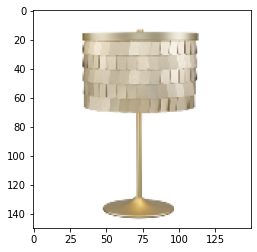

In [29]:
# смотрим на картинку

plt.imshow(img_tenzor[0])
plt.show()

In [30]:
# распознаем

prediction = network.predict(img_tenzor)

prediction

array([[1.5371240e-04, 9.9983573e-01, 1.0515582e-05]], dtype=float32)

In [31]:
# отображаем прогноз соответствия картинки каждой из категорий

for id, name in name_class.items():
  val = prediction[0][id]
  print(name + ' -> ' + str(val))


cell -> 0.0001537124
nastol -> 0.9998357
podves -> 1.0515582e-05


In [32]:
# Макс результат у класса

id_class_max = np.argmax(prediction)
print("MAX класс:", name_class[id_class_max])

MAX класс: nastol
